In [1]:
import json
import numpy as np
from glob import glob

from treem import Morph, SWC, SEG, get_segdata

In [2]:
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-(x - b) / c))

In [3]:
"""
def linsigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-(x - b) / c)) * (1 - (x - b) / d)
"""

'\ndef linsigmoid(x, a, b, c, d):\n    return a / (1 + np.exp(-(x - b) / c)) * (1 - (x - b) / d)\n'

In [4]:
densityfit = json.load(open('metadata/densityfit.json'))

In [5]:
def tot_spines(rec, fit, par):
    m = Morph(rec)
    d = get_segdata(m)
    spines = 0.0
    for seg in d:
        if seg[SEG.T] == SWC.DEND:
            dist, length = seg[SEG.PATH], seg[SEG.LENGTH]
            dens = fit(dist, *par)
            spines += dens*length
    return int(spines)

In [6]:
def seg_spines(rec, fit, par):
    m = Morph(rec)
    d = get_segdata(m)
    segspines = []
    for seg in d:
        if seg[SEG.T] == SWC.DEND:
            dist, length = seg[SEG.PATH], seg[SEG.LENGTH]
            dens = fit(dist, *par)
            spines = dens*length
            segspines.append([seg[SEG.ORDER], seg[SEG.BREADTH], spines])
    return segspines

In [7]:
mspines = []
mspines_seg = []
for rec in glob('../data/mouse/derived/release/*.swc'):
    mspines.append(tot_spines(rec, sigmoid, densityfit['Mouse']))
    #mspines_seg.extend(seg_spines(rec, sigmoid, densityfit['Mouse']))
    mspines_seg.append(seg_spines(rec, sigmoid, densityfit['Mouse']))

In [8]:
hspines = []
hspines_seg = []
for rec in glob('../data/human/derived/release/*.swc'):
    hspines.append(tot_spines(rec, sigmoid, densityfit['Human']))
    hspines_seg.append(seg_spines(rec, sigmoid, densityfit['Human']))

In [9]:
from scipy.stats import ttest_ind

def p_stars(x, y, pvalues=[0.001, 0.01, 0.05]):
    pv = ttest_ind(x, y).pvalue
    stars = 'n/s'
    if pv < pvalues[0]:
        stars = '***'
    elif pv < pvalues[1]:
        stars = '**'
    elif pv < pvalues[2]:
        stars = '*'
    return stars

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [11]:
Set1 = mpl.colormaps['Set1']
Pastel1 = mpl.colormaps['Pastel1']
mcolor = Set1(0.0)
hcolor = Set1(1.0/9)
mcolor_light = Pastel1(0.0)
hcolor_light = Pastel1(1.0/9)

In [12]:
import pandas as pd
import seaborn as sns

In [13]:
d1 = pd.DataFrame({"density": mspines, "species": ['Mouse']*len(mspines)})
d2 = pd.DataFrame({"density": hspines, "species": ['Human']*len(hspines)})
spines = pd.concat([d1, d2])

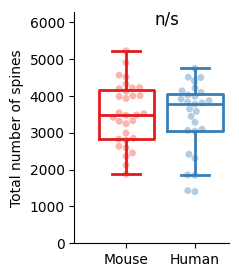

In [14]:
ax = plt.figure(figsize=(2, 3)).add_subplot()
sns.swarmplot(spines, x='species', y='density', hue='species', ax=ax, 
              size=5, palette=[mcolor_light, hcolor_light])
sns.boxplot(spines, x='species', y='density', hue='species', ax=ax, 
            zorder=3, fill=False, showfliers=False, linewidth=2,
            palette=[mcolor, hcolor])
ax.text(0.6, 0.95, p_stars(mspines, hspines), transform=ax.transAxes, ha='center', fontsize=12)

ax.set_ylabel('Total number of spines')
ax.set_xlabel('')
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(bottom=0, top=max(mspines)*1.2)
ax.set_xlim(left=-0.75)

plt.savefig('images/totspines-1.pdf')

In [15]:
mspines_term = []
for cell in mspines_seg:
    cell = np.array(cell)
    nspines = sum(cell[:,2])
    nterm = sum(cell[cell[:,1]==1][:,2])
    mspines_term.append(nterm / nspines * 100)

In [16]:
hspines_term = []
for cell in hspines_seg:
    cell = np.array(cell)
    nspines = sum(cell[:,2])
    nterm = sum(cell[cell[:,1]==1][:,2])
    hspines_term.append(nterm / nspines * 100)

In [17]:
t1 = pd.DataFrame({"density": mspines_term, "species": ['Mouse']*len(mspines_term)})
t2 = pd.DataFrame({"density": hspines_term, "species": ['Human']*len(hspines_term)})
term_spines = pd.concat([t1, t2])

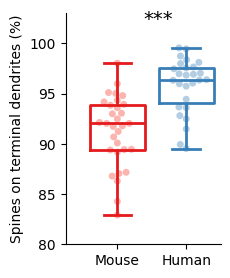

In [18]:
ax = plt.figure(figsize=(2, 3)).add_subplot()
sns.swarmplot(term_spines, x='species', y='density', hue='species', ax=ax, 
              size=5, palette=[mcolor_light, hcolor_light])
sns.boxplot(term_spines, x='species', y='density', hue='species', ax=ax, 
            zorder=3, fill=False, showfliers=False, linewidth=2,
            palette=[mcolor, hcolor])
ax.text(0.6, 0.95, p_stars(mspines_term, hspines_term), transform=ax.transAxes, ha='center', fontsize=14)

ax.set_ylabel('Spines on terminal dendrites (%)')
ax.set_xlabel('')
ax.spines[['right', 'top']].set_visible(False)
ax.set_yticks([80,85,90,95,100])
ax.set_ylim(80, 103)
ax.set_xlim(left=-0.75)

plt.savefig('images/totspines-2.pdf')

In [19]:
np.mean(mspines_term), np.mean(hspines_term)

(91.32358525125314, 95.8319311646114)